In [ ]:
!pip install category_encoders
!pip install catboost

     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 76.6 MB 38 kB/s 


In [ ]:
# Load all helper function
%run -i '../util/helper.py'

# Load Dataset and Data Split

In [ ]:
df  = pd.read_csv('../Dataset/brazilian_ecommerce_encoded.csv')
y = df["is_delayed"]
X = df.drop(["is_delayed", "Unnamed: 0.2"], axis=1, inplace=False)

In [ ]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [ ]:
print(X_dev.shape)
print(X_test.shape)

(92506, 29)
(23127, 29)


# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [ ]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start4 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}

pipe_CB_tune = Pipeline([('classifier',CatBoostClassifier(random_state=random_state))])

pipe_CB = make_pipeline(GridSearchCV(pipe_CB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_CB.fit(X_dev, np.ravel(y_dev))
end4 = time()
print("CatBoost model takes " + str(end4-start4) + "seconds")

0:	learn: 0.6285196	total: 80.3ms	remaining: 7.95s
1:	learn: 0.5708554	total: 110ms	remaining: 5.37s
2:	learn: 0.5230916	total: 137ms	remaining: 4.43s
3:	learn: 0.4810446	total: 164ms	remaining: 3.94s
4:	learn: 0.4447763	total: 193ms	remaining: 3.67s
5:	learn: 0.4129477	total: 219ms	remaining: 3.42s
6:	learn: 0.3867463	total: 245ms	remaining: 3.26s
7:	learn: 0.3632763	total: 271ms	remaining: 3.12s
8:	learn: 0.3432275	total: 318ms	remaining: 3.21s
9:	learn: 0.3260071	total: 346ms	remaining: 3.12s
10:	learn: 0.3114846	total: 372ms	remaining: 3.01s
11:	learn: 0.2999243	total: 400ms	remaining: 2.93s
12:	learn: 0.2884152	total: 425ms	remaining: 2.84s
13:	learn: 0.2783830	total: 452ms	remaining: 2.78s
14:	learn: 0.2694413	total: 480ms	remaining: 2.72s
15:	learn: 0.2620049	total: 506ms	remaining: 2.66s
16:	learn: 0.2551093	total: 535ms	remaining: 2.61s
17:	learn: 0.2488926	total: 563ms	remaining: 2.56s
18:	learn: 0.2427000	total: 588ms	remaining: 2.51s
19:	learn: 0.2392060	total: 614ms	remain

In [9]:
def str2bool(v):
  return v.lower() in ("yes", "true", "t", "1")

In [10]:
grid_search_CB = pipe_CB.named_steps["gridsearchcv"]
print(f"The CatBoost model Best hyperparameters is ", grid_search_CB.best_params_)

The CatBoost model Best hyperparameters is  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}


### Evaluate on the Test Set

In [11]:
CB_prediction = np.array([str2bool(p) for p in pipe_CB.predict(X_test)])

print(f'Accuracy: {accuracy_score(y_test,CB_prediction)}')
print(f'Recall: {recall_score(y_test,CB_prediction)}')
print(f'Precision: {precision_score(y_test,CB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,CB_prediction)}')

recall, precision = recall_score(y_test,CB_prediction), precision_score(y_test,CB_prediction)

Accuracy: 0.938772862887534
Recall: 0.2633390705679862
Precision: 0.7766497461928934
F-1 Score: 0.3933161953727507


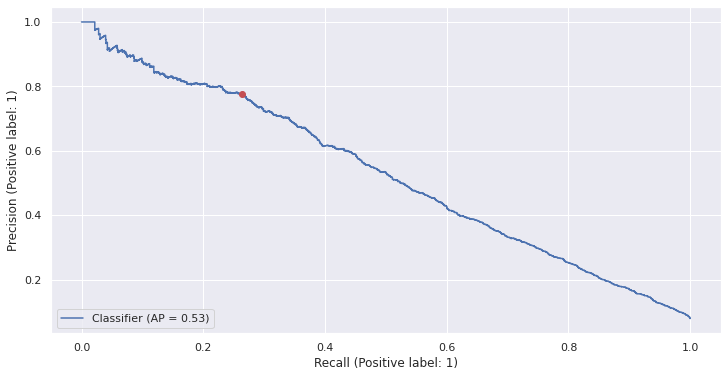

In [12]:
probs = pipe_CB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

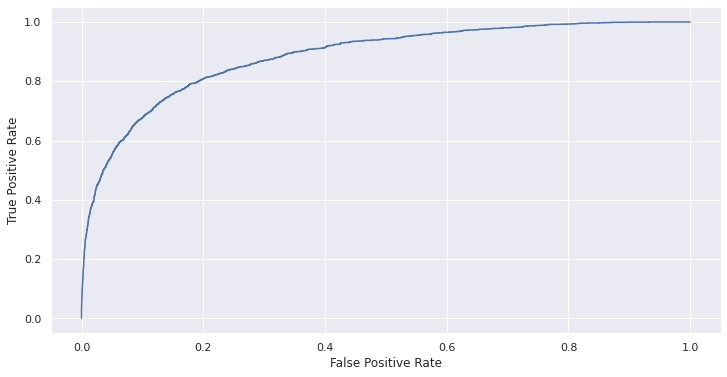

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

Feature Importances

In [24]:
feature_importances = grid_search_CB.best_estimator_[0].feature_importances_
d = {'Feature': X.columns,'Importance': feature_importances}
df = pd.DataFrame(d).sort_values(by='Importance', ascending=False)
df

,Feature,Importance
24,customer_city,31.02953
6,review_score,20.29702
14,month,12.77573
22,order_status,12.09283
26,seller_city,5.45658
13,year,4.83362
12,distance,3.02401
0,quantity,2.48845
2,freight_value,2.07794
15,day,1.31792


In [25]:
filename = '../Model/CatBoost_stratified.sav'
pickle.dump(pipe_CB, open(filename, 'wb'))

## Downsampling

In [26]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

### GridSearch

In [27]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start5 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}
pipe_CB_tune = Pipeline([('classifier',CatBoostClassifier(random_state=random_state))])
pipe_CB = make_pipeline(GridSearchCV(pipe_CB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_CB.fit(X_dev_us, np.ravel(y_dev_us))
end5 = time()
print("CatBoost model takes " + str(end5-start5) + "seconds")

0:	learn: 0.6749479	total: 9.6ms	remaining: 951ms
1:	learn: 0.6582738	total: 19.4ms	remaining: 953ms
2:	learn: 0.6405792	total: 27.6ms	remaining: 892ms
3:	learn: 0.6266771	total: 35.9ms	remaining: 861ms
4:	learn: 0.6120912	total: 44.2ms	remaining: 840ms
5:	learn: 0.6012070	total: 52.6ms	remaining: 825ms
6:	learn: 0.5915250	total: 60.8ms	remaining: 808ms
7:	learn: 0.5820492	total: 69ms	remaining: 793ms
8:	learn: 0.5736483	total: 77.7ms	remaining: 786ms
9:	learn: 0.5646101	total: 86.2ms	remaining: 775ms
10:	learn: 0.5581689	total: 94.5ms	remaining: 765ms
11:	learn: 0.5520259	total: 103ms	remaining: 758ms
12:	learn: 0.5458652	total: 111ms	remaining: 746ms
13:	learn: 0.5402933	total: 120ms	remaining: 736ms
14:	learn: 0.5347858	total: 128ms	remaining: 727ms
15:	learn: 0.5305017	total: 136ms	remaining: 716ms
16:	learn: 0.5252534	total: 144ms	remaining: 705ms
17:	learn: 0.5211359	total: 153ms	remaining: 695ms
18:	learn: 0.5174319	total: 162ms	remaining: 692ms
19:	learn: 0.5133554	total: 171ms

In [28]:
grid_search_CB = pipe_CB.named_steps["gridsearchcv"]
print(f"The CatBoost model Best hyperparameters is ", grid_search_CB.best_params_)

The CatBoost model Best hyperparameters is  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}


### Evaluate on the Test Set

In [29]:
CB_prediction = np.array([str2bool(p) for p in pipe_CB.predict(X_test)])

print(f'Accuracy: {accuracy_score(y_test,CB_prediction)}')
print(f'Recall: {recall_score(y_test,CB_prediction)}')
print(f'Precision: {precision_score(y_test,CB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,CB_prediction)}')

recall, precision = recall_score(y_test,CB_prediction), precision_score(y_test,CB_prediction)

Accuracy: 0.8247070523630389
Recall: 0.7762478485370051
Precision: 0.2696830775363763
F-1 Score: 0.40029585798816575


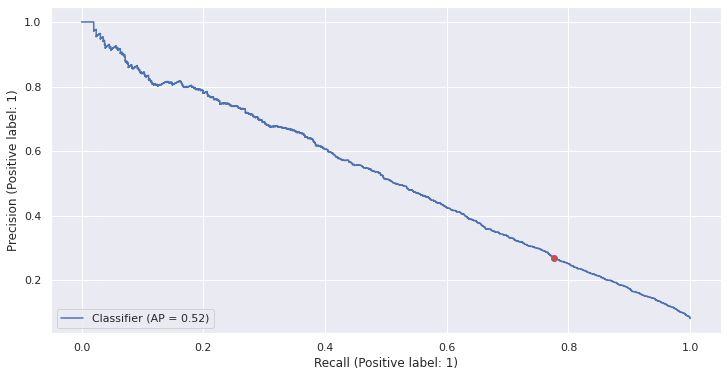

In [30]:
probs = pipe_CB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

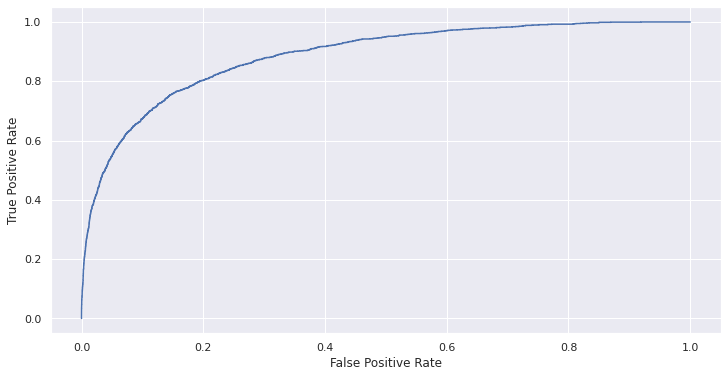

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

Feature Importances

In [32]:
feature_importances = grid_search_CB.best_estimator_[0].feature_importances_
d = {'Feature': X.columns,'Importance': feature_importances}
df = pd.DataFrame(d).sort_values(by='Importance', ascending=False)
df

,Feature,Importance
24,customer_city,28.74523
6,review_score,24.81509
14,month,14.81346
22,order_status,6.31464
26,seller_city,5.90848
13,year,5.36187
12,distance,2.96653
15,day,2.32242
0,quantity,2.22175
2,freight_value,1.62028


In [33]:
filename = '../Model/CatBoost_downsampling.sav'
pickle.dump(pipe_CB, open(filename, 'wb'))